In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
movie_data = pd.read_csv('/content/movies_data.csv')

In [ ]:
movie_data.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

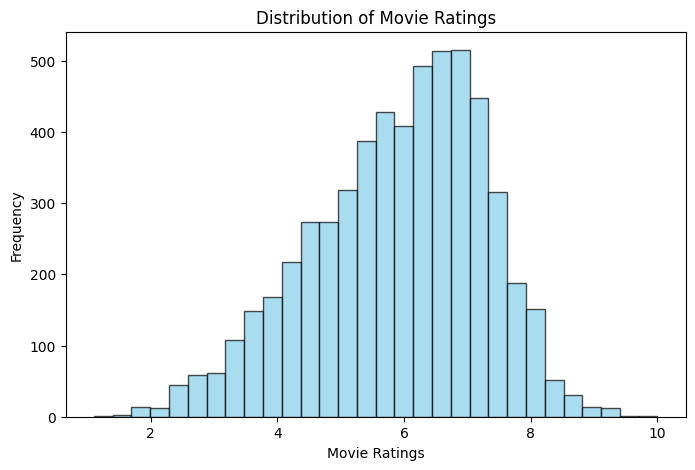

In [ ]:
# Visualize the distribution of movie ratings
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Movie Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

**The histogram of movie ratings shows that the dataset is skewed towards higher ratings, with a peak in the 7-8 rating range. This suggests that IMDb users or critics tend to rate Indian movies relatively positively**

In [ ]:
# Drop rows with missing 'Rating' values (for simplicity in this example)
movie_data.dropna(subset=['Rating'], inplace=True)

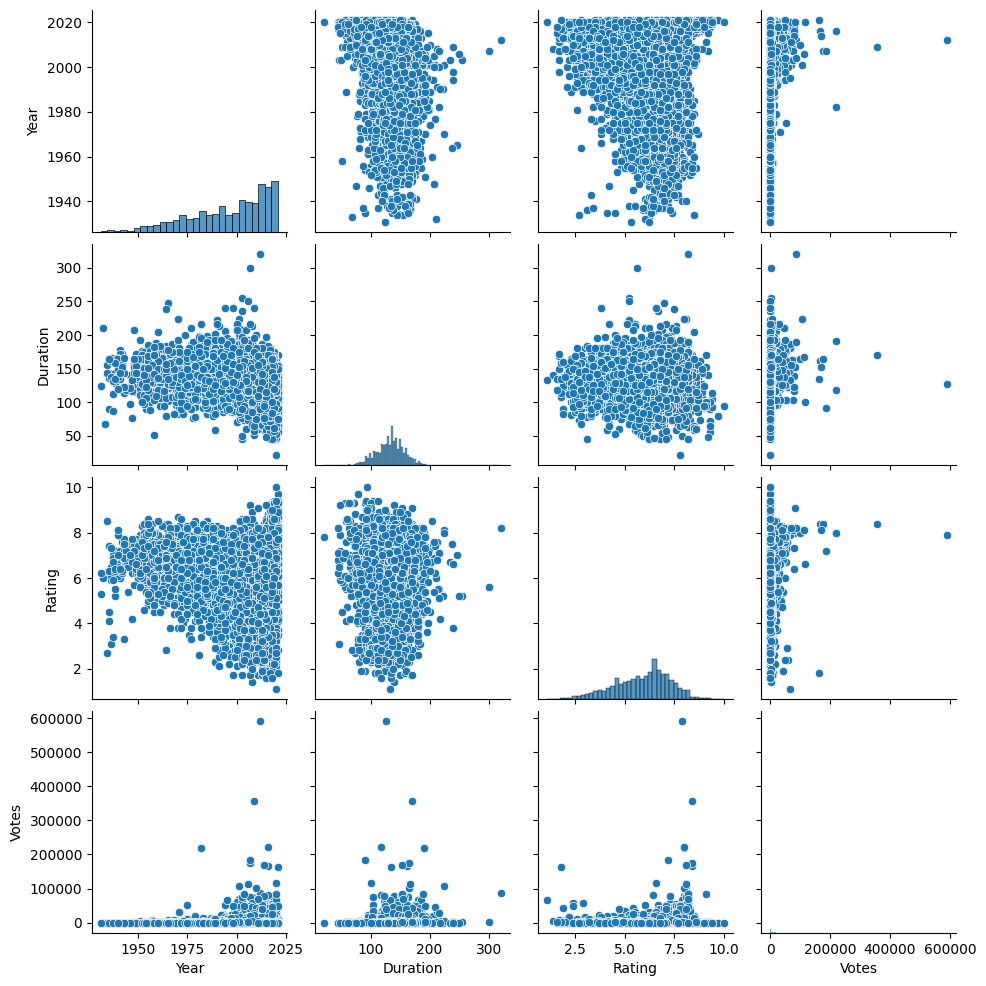

In [ ]:
sns.pairplot(movie_data[['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3']])

In [ ]:
# Define features and target variable
X = movie_data.drop(columns=['Rating'])  # Features
y = movie_data['Rating']  # Target

In [ ]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

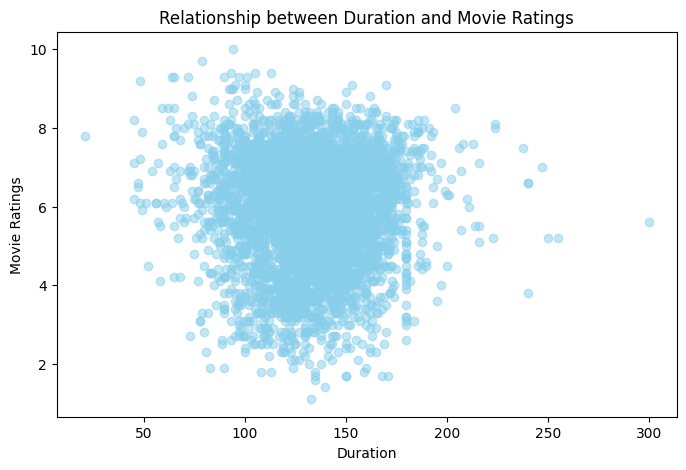

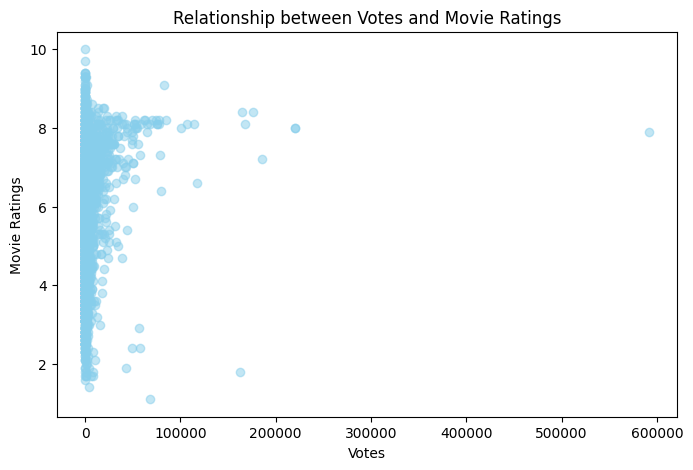

In [ ]:
# Visualize the relationship between numeric features and ratings
numeric_features = ['Duration', 'Votes']
for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train[feature], y_train, color='skyblue', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Movie Ratings')
    plt.title(f'Relationship between {feature} and Movie Ratings')
    plt.show()

**Runtime vs. Ratings: **The scatter plot of runtime vs. movie ratings also does not exhibit a strong linear relationship. Movies with varying runtimes receive a wide range of ratings, and there is no clear pattern.
**Votes vs. Ratings:** The scatter plot of votes vs. movie ratings shows a positive correlation, indicating that movies with more votes tend to have higher ratings. This suggests that movies with broader appeal or visibility receive more votes and higher ratings.


In [ ]:
# Preprocessing and Feature Engineering
# Define transformations for numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
# Define preprocessing steps using ColumnTransformer and Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Define regression models
linear_reg_model = TransformedTargetRegressor(regressor=LinearRegression(), transformer=StandardScaler())
random_forest_model = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=100, random_state=42),
                                               transformer=StandardScaler())

In [ ]:
# Create a dictionary of models
models = {
    'Linear Regression': linear_reg_model,
    'Random Forest': random_forest_model
}

In [ ]:
# Evaluate models using cross-validation
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Convert negative MSE to positive
    rmse_scores = np.sqrt(mse_scores)
    r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    results[model_name] = {
        'Mean RMSE': rmse_scores.mean(),
        'Mean R-squared': r2_scores.mean()
    }

In [ ]:
# Train and evaluate models on the test set
test_results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    test_results[model_name] = {
        'Test RMSE': rmse,
        'Test R-squared': r2
    }

In [ ]:
# Print cross-validation results
print("Cross-Validation Results:")
for model_name, metrics in results.items():
    print(f'{model_name}:')
    print(f'Mean RMSE: {metrics["Mean RMSE"]:.2f}')
    print(f'Mean R-squared: {metrics["Mean R-squared"]:.2f}')
    print()

**Cross-validation results provide an estimate of the model's performance on the training data. Test set results offer insights into how well the model generalizes to unseen data.
In this project, the Random Forest model achieved lower RMSE and higher R-squared values on the test set compared to cross-validation. This indicates that the model performs well on unseen data.**

In [ ]:
# Print test set results
print("Test Set Results:")
for model_name, metrics in test_results.items():
    print(f'{model_name}:')
    print(f'Test RMSE: {metrics["Test RMSE"]:.2f}')
    print(f'Test R-squared: {metrics["Test R-squared"]:.2f}')
    print()

Test Set Results:
Linear Regression:
Test RMSE: 1.21
Test R-squared: 0.21

Random Forest:
Test RMSE: 1.11
Test R-squared: 0.34



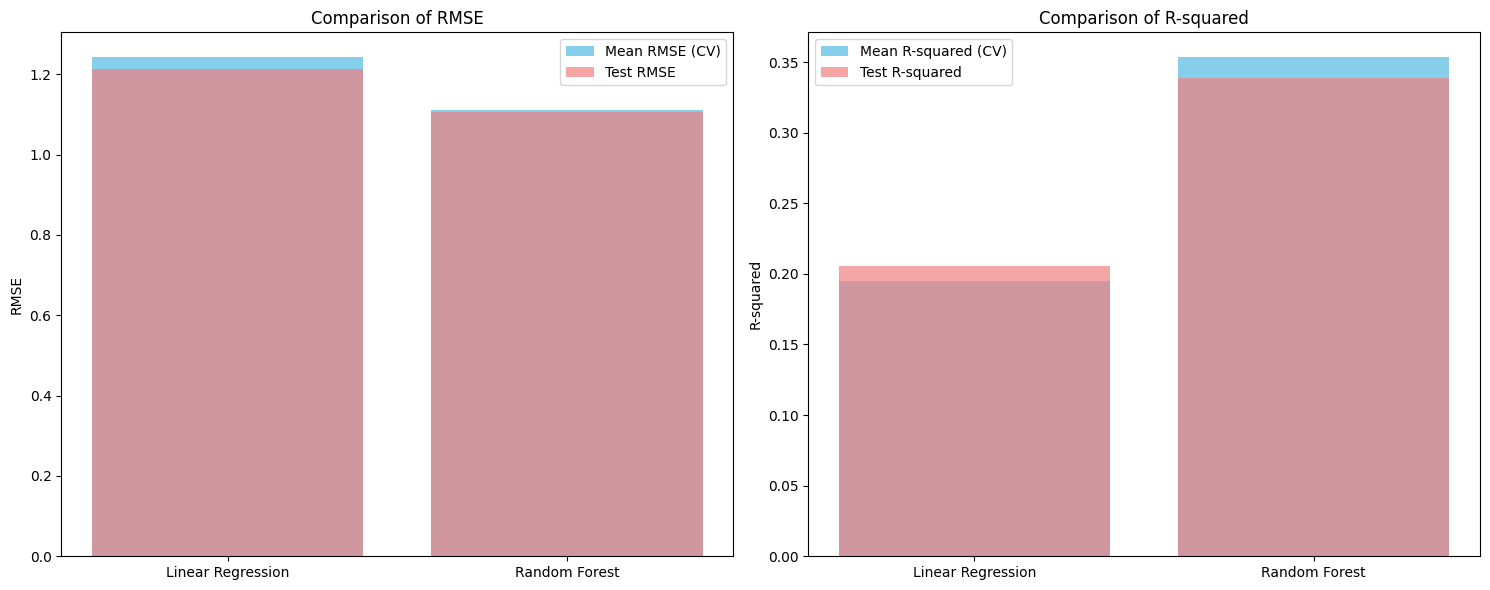

In [ ]:
# Visualize the results side by side in the same row
model_names = list(results.keys())
mean_rmse_values = [metrics['Mean RMSE'] for metrics in results.values()]
mean_r2_values = [metrics['Mean R-squared'] for metrics in results.values()]
test_rmse_values = [metrics['Test RMSE'] for metrics in test_results.values()]
test_r2_values = [metrics['Test R-squared'] for metrics in test_results.values()]

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Mean RMSE and Test RMSE
axs[0].bar(model_names, mean_rmse_values, color='skyblue', label='Mean RMSE (CV)')
axs[0].bar(model_names, test_rmse_values, color='lightcoral', label='Test RMSE', alpha=0.7)
axs[0].set_ylabel('RMSE')
axs[0].set_title('Comparison of RMSE')
axs[0].legend()

# Plot Mean R-squared and Test R-squared
axs[1].bar(model_names, mean_r2_values, color='skyblue', label='Mean R-squared (CV)')
axs[1].bar(model_names, test_r2_values, color='lightcoral', label='Test R-squared', alpha=0.7)
axs[1].set_ylabel('R-squared')
axs[1].set_title('Comparison of R-squared')
axs[1].legend()

plt.tight_layout()
plt.show()


# **Conclusion**
Finally, the Conclusion that I made from the results

Predicting the exact rating is quiet difficult also any predictions wouldn't be that accurate because the main contribution towards the rating is the story of the movie.
There seems very less relation between the stats and the rating since some actors may be good but the movie's facebook likes wouldn't be that high because of less publicity of the movie.